Libraries

In [187]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.stem.porter import *
import re

# for visualisation
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# tensor packages
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, Conv1D, Dropout, Bidirectional, LSTM, Input, Concatenate, BatchNormalization
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

# hide warnings
import warnings 
warnings.filterwarnings("ignore")

--------------

For GPU

In [188]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [189]:
# Set up GPU usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

In [190]:
# To check if GPU is available
tf.config.list_physical_devices('GPU') #Unfortunatly don't have any GPU

[]

Data Loading

In [191]:
training_data = pd.read_csv('Data/train.csv', index_col = [0])

In [192]:
test_data = pd.read_csv('Data/test.csv', index_col = [0])

------

Preprocessing

In [193]:
training_data.product_description = training_data.product_description.fillna('')
test_data.product_description = test_data.product_description.fillna('')

In [194]:
# stop word removal
stemmer = PorterStemmer()
sw=[]
ML_STOP_WORDS = ['http','www','img','border','color','style','padding','table','font','inch','width','height']
ML_STOP_WORDS += list(text.ENGLISH_STOP_WORDS)
for stw in ML_STOP_WORDS:
    sw.append("z"+str(stw))
ML_STOP_WORDS += sw
for i in range(len(ML_STOP_WORDS)):
    ML_STOP_WORDS[i]=stemmer.stem(ML_STOP_WORDS[i])

In [195]:
# declarations
def ML_TEXT_CLEAN(f2,f3):
    if len(f2)<3:
        f2="feature2null"
    if len(f3)<3:
        f3="feature3null"
    tx = BeautifulSoup(f3)
    tx1 = [x.extract() for x in tx.findAll('script')]
    tx = tx.get_text(" ").strip()
    #s = (" ").join(["z"+ str(z) for z in f2.split(" ")]) + " " + tx
    s = (" ").join([str(z) for z in f2.split(" ")]) + " " + tx
    s = re.sub("[^a-zA-Z0-9]"," ", s)
    s = re.sub("[0-9]{1,3}px"," ", s)
    s = re.sub(" [0-9]{1,6} |000"," ", s)
    s = (" ").join([stemmer.stem(z) for z in s.split(" ") if len(z)>2])
    s = s.lower()
    return s

In [196]:
# Cleaning training data
s_data = []
for i in range(len(training_data.id)):
    s = ML_TEXT_CLEAN(training_data.product_title[i], training_data.product_description[i])
    s_data.append((training_data["query"][i], s, str(training_data["median_relevance"][i])))

In [197]:
# Cleaning test data
t_data = []
for i in range(len(test_data.id)):
    s = ML_TEXT_CLEAN(test_data.product_title[i], test_data.product_description[i])
    t_data.append((test_data["query"][i], s, str(test_data["median_relevance"][i])))

In [198]:
# Converting into dataframe
training_df = pd.DataFrame(s_data)
test_df = pd.DataFrame(t_data)

In [199]:
# Shape of data
print('training data shape : ', training_df.shape) # (7618, 3)
print('test data shape : ', test_df.shape) # (2540, 3)

training data shape :  (7618, 3)
test data shape :  (2540, 3)


In [200]:
# Training data unique targeted values
np.unique(training_df[2], return_counts=True)

(array(['1', '2', '3', '4'], dtype=object),
 array([ 588, 1139, 1286, 4605], dtype=int64))

In [201]:
# Test data unique targeted values
np.unique(test_df[2], return_counts=True)

(array(['1', '2', '3', '4'], dtype=object),
 array([ 186,  337,  451, 1566], dtype=int64))

In [202]:
# Shape of whole data
print('training_df[[0,1]] shape : ', training_df[[0,1]].shape)
print('training_df[2] shape : ', training_df[2].shape)
print('test_df[[0,1]] shape : ', test_df[[0,1]].shape)
print('test_df[2] shape : ', test_df[2].shape)

training_df[[0,1]] shape :  (7618, 2)
training_df[2] shape :  (7618,)
test_df[[0,1]] shape :  (2540, 2)
test_df[2] shape :  (2540,)


In [203]:
# Type of data
print(training_df[[0,1]].dtypes)

0    object
1    object
dtype: object




---



**BiLSTM**

In [204]:
# Create input data
train_data = training_df[[0,1]]
test_data = test_df[[0,1]] 

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data[0].values + train_data[1].values)

In [205]:
# Convert the text data to sequences
train_text1_sequences = tokenizer.texts_to_sequences(train_data[0].values)
train_text2_sequences = tokenizer.texts_to_sequences(train_data[1].values)
test_text1_sequences = tokenizer.texts_to_sequences(test_data[0].values)
test_text2_sequences = tokenizer.texts_to_sequences(test_data[1].values)

# Pad the sequences to a fixed length
max_sequence_length = 300
train_text1_data = pad_sequences(train_text1_sequences, maxlen=max_sequence_length)
train_text2_data = pad_sequences(train_text2_sequences, maxlen=max_sequence_length)
test_text1_data = pad_sequences(test_text1_sequences, maxlen=max_sequence_length)
test_text2_data = pad_sequences(test_text2_sequences, maxlen=max_sequence_length)

In [206]:
# Initialize a label encoder
label_encoder = LabelEncoder()

# Fit the encoder to the class labels and transform the labels to integers
y_train_encoded = label_encoder.fit_transform(training_df[2])
y_test_encoded = label_encoder.fit_transform(test_df[2])

# Convert the output data to one-hot encoded format
train_output_data = tf.keras.utils.to_categorical(y_train_encoded, num_classes=4)
test_output_data = tf.keras.utils.to_categorical(y_test_encoded, num_classes=4)

In [218]:
# Define the model architecture
embedding_dim = 300
lstm_units = 32
input1 = Input(shape=(max_sequence_length,))
input2 = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)
x1 = embedding_layer(input1)
x2 = embedding_layer(input2)

lstm_layer = Bidirectional(LSTM(units=lstm_units, dropout=0.4, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

x1 = lstm_layer(x1)
x2 = lstm_layer(x2)
merged = tf.keras.layers.concatenate([x1, x2])
output_layer = Dense(units=4, activation='softmax')
output = output_layer(merged)
model = Model(inputs=[input1, input2], outputs=output)

In [219]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [220]:
# Model summary
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 300, 300)     6330000     ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 bidirectional_7 (Bidirectional  (None, 64)          85248       ['embedding_7[0][0]',     

In [221]:
# Train the model
history1 = model.fit([train_text1_data, train_text2_data], train_output_data, epochs=10, batch_size=150, validation_split=0.2, callbacks=[early_stop])

Epoch 1/10
41/41 [==============================] - 115s 3s/step - loss: 3.9762 - accuracy: 0.5950 - val_loss: 2.8394 - val_accuracy: 0.5951
Epoch 2/10
41/41 [==============================] - 94s 2s/step - loss: 2.2810 - accuracy: 0.6068 - val_loss: 1.9283 - val_accuracy: 0.5951
Epoch 3/10
41/41 [==============================] - 104s 3s/step - loss: 1.6703 - accuracy: 0.6131 - val_loss: 1.6225 - val_accuracy: 0.6109
Epoch 4/10
41/41 [==============================] - 107s 3s/step - loss: 1.3910 - accuracy: 0.6572 - val_loss: 1.5485 - val_accuracy: 0.5906
Epoch 5/10
41/41 [==============================] - 114s 3s/step - loss: 1.2328 - accuracy: 0.6940 - val_loss: 1.5233 - val_accuracy: 0.5728
Epoch 6/10
41/41 [==============================] - 107s 3s/step - loss: 1.1206 - accuracy: 0.7210 - val_loss: 1.6373 - val_accuracy: 0.5774
Epoch 7/10
41/41 [==============================] - 106s 3s/step - loss: 1.0098 - accuracy: 0.7670 - val_loss: 1.6278 - val_accuracy: 0.5256
Epoch 8/10
41/

In [223]:
# Model loss graph
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Loss', 'Validation Loss'))

fig.add_trace(go.Scatter(x=list(range(1, len(history1.history['loss'])+1)), y=history1.history['loss'], name='Training'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history1.history['val_loss'])+1)), y=history1.history['val_loss'], name='Validation'), row=1, col=2)

fig.update_layout(height=400, width=800, title_text="Model Loss")
fig.show()


In [224]:
# Model Accuracy graph
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Accuracy', 'Validation Accuracy'))

fig.add_trace(go.Scatter(x=list(range(1, len(history1.history['accuracy'])+1)), y=history1.history['accuracy'], name='Training'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history1.history['val_accuracy'])+1)), y=history1.history['val_accuracy'], name='Validation'), row=1, col=2)

fig.update_layout(height=400, width=800, title_text="Model Accuracy")
fig.show()

For test data

In [225]:
# Evaluate the model on the testing data
loss, accuracy = model.evaluate([test_text1_data, test_text2_data], test_output_data, batch_size=150)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

17/17 [==============================] - 8s 437ms/step - loss: 1.6284 - accuracy: 0.5488
Test loss: 1.6284446716308594
Test accuracy: 0.5488188862800598


In [226]:
# predict target values on the test data
preds = model.predict([test_text1_data, test_text2_data])

# convert the predicted values to the original labels
preds = np.argmax(preds, axis=1)

# convert the test labels to the original labels
y_test = np.argmax(test_output_data, axis=1)

# print the classification report
print(classification_report(y_test, preds))

80/80 [==============================] - 16s 175ms/step
              precision    recall  f1-score   support

           0       0.31      0.22      0.26       186
           1       0.26      0.19      0.22       337
           2       0.23      0.25      0.24       451
           3       0.70      0.75      0.73      1566

    accuracy                           0.55      2540
   macro avg       0.38      0.35      0.36      2540
weighted avg       0.53      0.55      0.54      2540



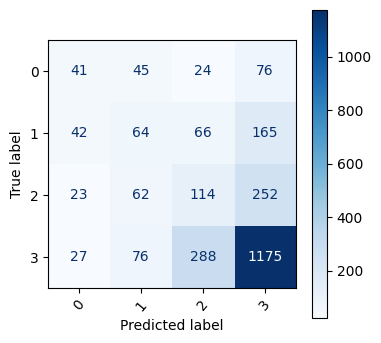

In [227]:
# plot the confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
disp.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()

Hyperparameter tuning

1st run: lstm_units = 32, dropout = 0.4, embedding_dim = 300 and l2 regularizer = 0.01

2nd run: lstm_units = 64, dropout = 0.6, embedding_dim = 300 and l2 regularizer = 0.1

3rd run: lstm_units = 16, dropout = 0.2, embedding_dim = 300 and l2 regularizer = 0.001

2nd run:

In [228]:
# Define the model architecture
embedding_dim_2 = 300
lstm_units_2 = 64
embedding_layer_2 = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim_2)
x1_2 = embedding_layer_2(input1)
x2_2 = embedding_layer_2(input2)

lstm_layer_2 = Bidirectional(LSTM(units=lstm_units_2, dropout=0.6, kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))

x1_2 = lstm_layer_2(x1_2)
x2_2 = lstm_layer_2(x2_2)
merged_2 = tf.keras.layers.concatenate([x1_2, x2_2])
output_layer_2 = Dense(units=4, activation='softmax')
output_2 = output_layer_2(merged_2)
model2 = Model(inputs=[input1, input2], outputs=output_2)

In [229]:
# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the early stopping callback
early_stop_2 = EarlyStopping(monitor='val_loss', patience=3)

In [230]:
# Train the model
history2 = model2.fit([train_text1_data, train_text2_data], train_output_data, epochs=10, batch_size=150, validation_split=0.2, callbacks=[early_stop_2])

Epoch 1/10
41/41 [==============================] - 262s 6s/step - loss: 44.9288 - accuracy: 0.5880 - val_loss: 26.8822 - val_accuracy: 0.5951
Epoch 2/10
41/41 [==============================] - 147s 4s/step - loss: 19.5464 - accuracy: 0.6068 - val_loss: 14.5818 - val_accuracy: 0.5951
Epoch 3/10
41/41 [==============================] - 149s 4s/step - loss: 12.6668 - accuracy: 0.6068 - val_loss: 11.4098 - val_accuracy: 0.5951
Epoch 4/10
41/41 [==============================] - 148s 4s/step - loss: 10.6750 - accuracy: 0.6093 - val_loss: 10.2228 - val_accuracy: 0.5978
Epoch 5/10
41/41 [==============================] - 149s 4s/step - loss: 9.6054 - accuracy: 0.6362 - val_loss: 9.4060 - val_accuracy: 0.5899
Epoch 6/10
41/41 [==============================] - 150s 4s/step - loss: 8.7985 - accuracy: 0.6520 - val_loss: 8.7178 - val_accuracy: 0.5545
Epoch 7/10
41/41 [==============================] - 148s 4s/step - loss: 7.9947 - accuracy: 0.6849 - val_loss: 8.1002 - val_accuracy: 0.5341
Epoch

In [231]:
# Model loss graph
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Loss', 'Validation Loss'))

fig.add_trace(go.Scatter(x=list(range(1, len(history2.history['loss'])+1)), y=history2.history['loss'], name='Training'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history2.history['val_loss'])+1)), y=history2.history['val_loss'], name='Validation'), row=1, col=2)

fig.update_layout(height=400, width=800, title_text="Model Loss")
fig.show()

In [232]:
# Model Accuracy graph
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Accuracy', 'Validation Accuracy'))

fig.add_trace(go.Scatter(x=list(range(1, len(history2.history['accuracy'])+1)), y=history2.history['accuracy'], name='Training'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history2.history['val_accuracy'])+1)), y=history2.history['val_accuracy'], name='Validation'), row=1, col=2)

fig.update_layout(height=400, width=800, title_text="Model Accuracy")
fig.show()

For test data:

In [233]:
# Evaluate the model on the testing data
loss, accuracy = model2.evaluate([test_text1_data, test_text2_data], test_output_data, batch_size=150)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

17/17 [==============================] - 12s 695ms/step - loss: 6.3736 - accuracy: 0.5457
Test loss: 6.37362003326416
Test accuracy: 0.5456693172454834


In [234]:
# predict target values on the test data
preds_2 = model2.predict([test_text1_data, test_text2_data])

# convert the predicted values to the original labels
preds_2 = np.argmax(preds_2, axis=1)

# convert the test labels to the original labels
y_test_2 = np.argmax(test_output_data, axis=1)

# print the classification report
print(classification_report(y_test_2, preds_2))

80/80 [==============================] - 21s 233ms/step
              precision    recall  f1-score   support

           0       0.44      0.02      0.04       186
           1       0.23      0.20      0.22       337
           2       0.20      0.19      0.20       451
           3       0.68      0.78      0.73      1566

    accuracy                           0.55      2540
   macro avg       0.39      0.30      0.30      2540
weighted avg       0.52      0.55      0.52      2540



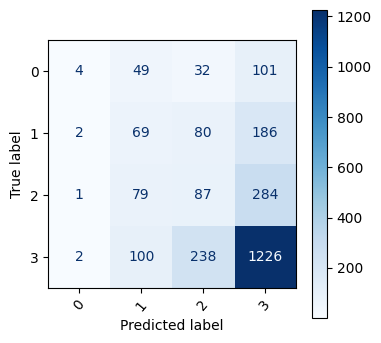

In [235]:
# plot the confusion matrix
cm_2 = confusion_matrix(y_test_2, preds_2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)

disp_2.plot(cmap=plt.cm.Blues)
disp_2.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()

3rd run

In [236]:
# Define the model architecture
embedding_dim_3 = 300
lstm_units_3 = 16
embedding_layer_3 = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim_3)
x1_3 = embedding_layer_3(input1)
x2_3 = embedding_layer_3(input2)

lstm_layer_3 = Bidirectional(LSTM(units=lstm_units_3, dropout=0.2, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))

x1_3 = lstm_layer_2(x1_3)
x2_3 = lstm_layer_2(x2_3)
merged_3 = tf.keras.layers.concatenate([x1_3, x2_3])
output_layer_3 = Dense(units=4, activation='softmax')
output_3 = output_layer_3(merged_3)
model3 = Model(inputs=[input1, input2], outputs=output_3)

In [237]:
# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the early stopping callback
early_stop_3 = EarlyStopping(monitor='val_loss', patience=3)

In [238]:
# Train the model
history3 = model3.fit([train_text1_data, train_text2_data], train_output_data, epochs=10, batch_size=150, validation_split=0.2, callbacks=[early_stop_3])

Epoch 1/10
41/41 [==============================] - 158s 4s/step - loss: 5.9716 - accuracy: 0.5824 - val_loss: 5.6598 - val_accuracy: 0.5951
Epoch 2/10
41/41 [==============================] - 152s 4s/step - loss: 5.3167 - accuracy: 0.6068 - val_loss: 5.0301 - val_accuracy: 0.5951
Epoch 3/10
41/41 [==============================] - 147s 4s/step - loss: 4.7448 - accuracy: 0.6068 - val_loss: 4.4988 - val_accuracy: 0.5951
Epoch 4/10
41/41 [==============================] - 150s 4s/step - loss: 4.2438 - accuracy: 0.6068 - val_loss: 4.0272 - val_accuracy: 0.5951
Epoch 5/10
41/41 [==============================] - 147s 4s/step - loss: 3.7964 - accuracy: 0.6068 - val_loss: 3.6085 - val_accuracy: 0.5951
Epoch 6/10
41/41 [==============================] - 146s 4s/step - loss: 3.4007 - accuracy: 0.6068 - val_loss: 3.2419 - val_accuracy: 0.5951
Epoch 7/10
41/41 [==============================] - 146s 4s/step - loss: 3.0542 - accuracy: 0.6068 - val_loss: 2.9128 - val_accuracy: 0.5951
Epoch 8/10
41

In [239]:
# Model loss graph
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Loss', 'Validation Loss'))

fig.add_trace(go.Scatter(x=list(range(1, len(history3.history['loss'])+1)), y=history3.history['loss'], name='Training'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history3.history['val_loss'])+1)), y=history3.history['val_loss'], name='Validation'), row=1, col=2)

fig.update_layout(height=400, width=800, title_text="Model Loss")
fig.show()

In [240]:
# Model Accuracy graph
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training Accuracy', 'Validation Accuracy'))

fig.add_trace(go.Scatter(x=list(range(1, len(history3.history['accuracy'])+1)), y=history3.history['accuracy'], name='Training'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history3.history['val_accuracy'])+1)), y=history3.history['val_accuracy'], name='Validation'), row=1, col=2)

fig.update_layout(height=400, width=800, title_text="Model Accuracy")
fig.show()

For test data:

In [241]:
# Evaluate the model on the testing data
loss, accuracy = model3.evaluate([test_text1_data, test_text2_data], test_output_data, batch_size=150)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

17/17 [==============================] - 12s 690ms/step - loss: 2.2563 - accuracy: 0.6142
Test loss: 2.2563087940216064
Test accuracy: 0.6141732335090637


In [242]:
# predict target values on the test data
preds_3 = model3.predict([test_text1_data, test_text2_data])

# convert the predicted values to the original labels
preds_3 = np.argmax(preds_3, axis=1)

# convert the test labels to the original labels
y_test_3 = np.argmax(test_output_data, axis=1)

# print the classification report
print(classification_report(y_test_3, preds_3))

80/80 [==============================] - 23s 261ms/step
              precision    recall  f1-score   support

           0       0.28      0.12      0.17       186
           1       0.00      0.00      0.00       337
           2       0.26      0.06      0.10       451
           3       0.64      0.96      0.77      1566

    accuracy                           0.61      2540
   macro avg       0.29      0.29      0.26      2540
weighted avg       0.46      0.61      0.51      2540



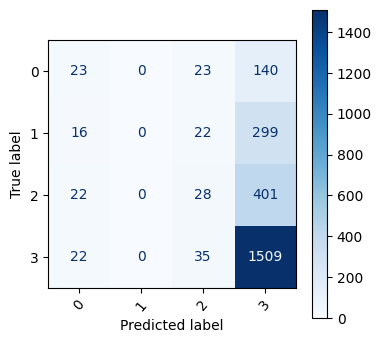

In [243]:
# plot the confusion matrix
cm_3 = confusion_matrix(y_test_3, preds_3)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3)

disp_3.plot(cmap=plt.cm.Blues)
disp_3.figure_.set_size_inches(4,4)
plt.xticks(rotation=50)
plt.show()